## **1. imports**

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

## 한글 폰트 표시
plt.rcParams['font.family'] ='NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

## 렌더링 설정
pio.templates.default = 'plotly_white'
pio.renderers.default = "vscode"

## **2. Data**

In [2]:
housing_price = pd.read_csv("kc_house_data.csv")
housing_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

## **3. Visualization & EDA**

### **A. 예측변수 주택 판매 가격의 분포**

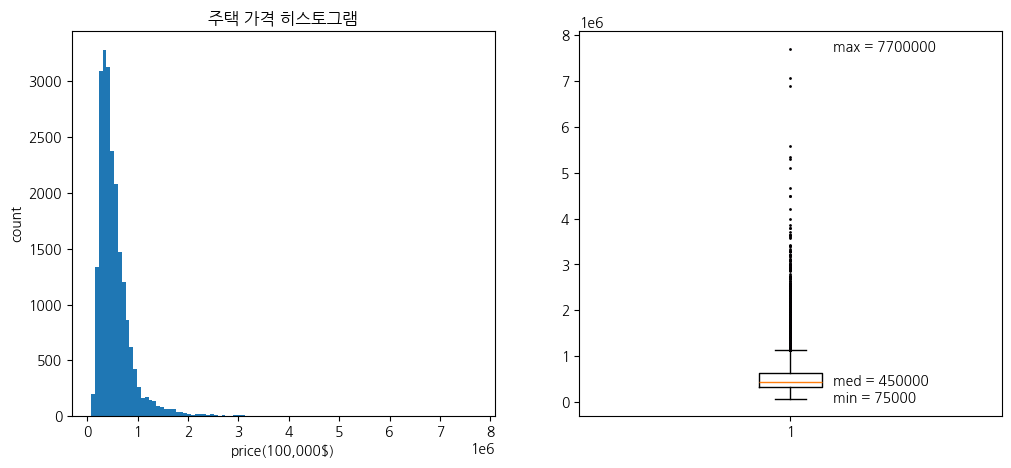

In [3]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))

axs[0].hist(housing_price.price, bins = 100)
axs[0].set_title("주택 가격 히스토그램")
axs[0].set_xlabel("price(100,000$)")
axs[0].set_ylabel("count")
axs[1].boxplot(housing_price.price, flierprops={'marker': 'o', 'markersize': 1, 'markerfacecolor': 'fuchsia'})
axs[1].text(1.1, 0, f"min = {housing_price.price.min():.0f}", fontsize=10)
axs[1].text(1.1, 375000, f"med = {housing_price.price.median():.0f}", fontsize=10)
axs[1].text(1.1, 7650000, f"max = {housing_price.price.max():.0f}", fontsize=10)
plt.show()

### **B. 각 설명변수들과 예측변수 간 관계 파악**

`-` 개별 설명변수(구매일자 제외)와 예측변수 간 산점도

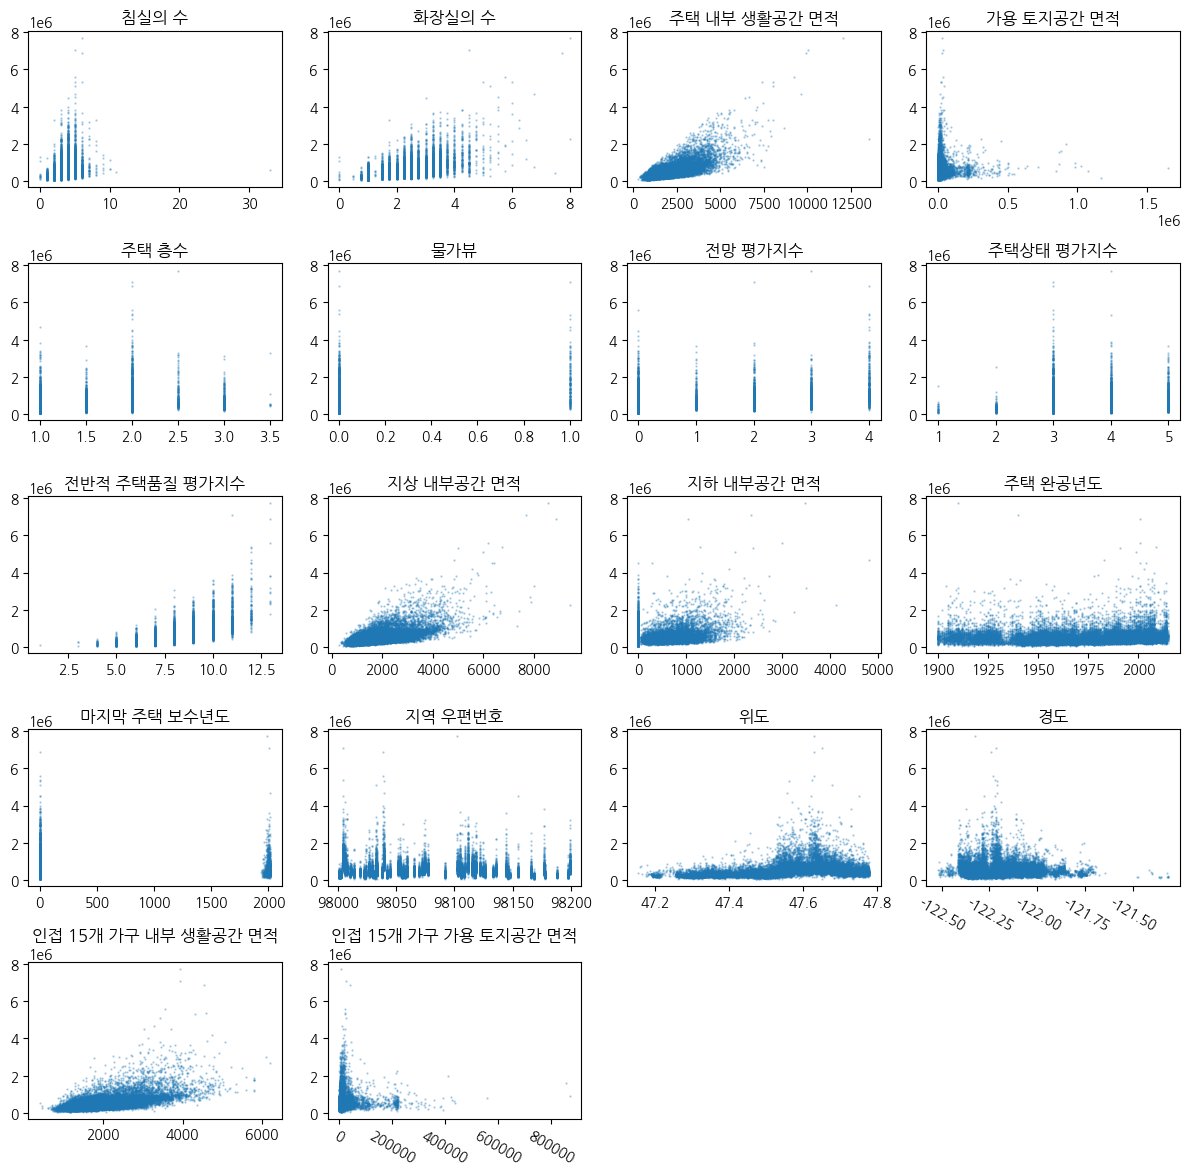

In [4]:
## 열 설명 딕셔너리 작성
description_list = ["ID", "주택 거래일", "주택 판매가격", "침실의 수", "화장실의 수", "주택 내부 생활공간 면적",
                    "가용 토지공간 면적", "주택 층수", "물가뷰", "전망 평가지수", "주택상태 평가지수", "전반적 주택품질 평가지수",
                    "지상 내부공간 면적", "지하 내부공간 면적", "주택 완공년도", "마지막 주택 보수년도", "지역 우편번호",
                    "위도", "경도", "인접 15개 가구 내부 생활공간 면적", "인접 15개 가구 가용 토지공간 면적"]

data_dict = {v:d for v, d in zip(housing_price.columns, description_list)}

## 시각화를 위한 전처리
df_preprocessed = housing_price.drop(["id", "date", "price"], axis = 1).assign(date = pd.to_datetime(housing_price.date)).assign(price = housing_price.price)
col_list = df_preprocessed.columns

## 산점도
fig, axs = plt.subplots(5, 4, figsize = (12,12))

for i in range(5) :
    for j in range(4) :
        if (i*4+j >= 18) :
            break
            
        axs[i, j].scatter(df_preprocessed.iloc[:, i*4+j], df_preprocessed.price, s = 0.5, alpha = 0.3)
        axs[i, j].set_title(data_dict[col_list[i*4+j]])

        if col_list[i*4+j] in ("long", "sqft_lot15") :
            axs[i, j].tick_params(axis='x', rotation=-30)

axs[4, 2].remove()
axs[4, 3].remove()
fig.tight_layout()
plt.show()

`-` 구매 일자 관련 시각화

In [5]:
## 월별 주택 판매가격 상자 그림
fig = go.Figure()
fig.add_trace(
    go.Box(
        x = df_preprocessed.date.dt.month, y = df_preprocessed.price,
        notched=True
    )
)

fig.update_layout(title=dict(text="월별 주택 판매 가격에 대한 상자 그림", font=dict(size=30), x = 0.5, y = 0.95), height = 800)
fig.update_xaxes(dtick=1)
fig.show()

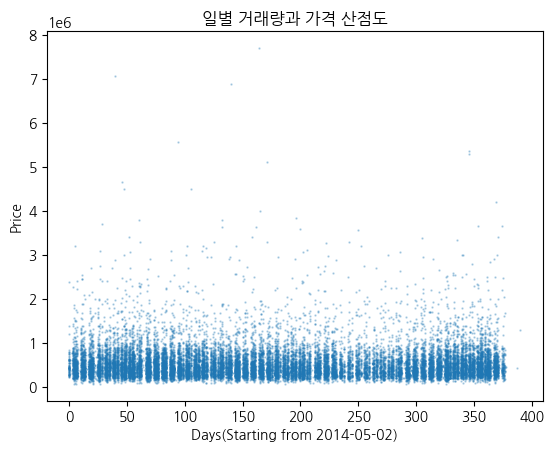

In [6]:
## 주택 판매일과 주택 가격 간 산점도
basis = df_preprocessed.date.min() ## timestamp 2014-05-02

plt.scatter(df_preprocessed.date.map(lambda x : x - basis).dt.days, df_preprocessed.price, s = 0.5, alpha = 0.3)
plt.title("일별 거래량과 가격 산점도")
plt.xlabel("Days(Starting from 2014-05-02)")
plt.ylabel("Price")
plt.show()

### **C. 변수 간 선형 상관계수 히트맵(절대값 스케일)**

In [7]:
## generating tidy data
tidy_data = df_preprocessed.corr().stack().reset_index().rename({"level_0" : "var1", "level_1" : "var2", 0 : "correlation"}, axis = 1)\
.assign(abs_corr = lambda _df : _df.correlation.map(lambda x : abs(x)))
tidy_data = pd.concat([tidy_data.loc[tidy_data.var1 == 'bedrooms'][::-1], tidy_data.iloc[20:, :]], axis = 0)

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = tidy_data.var1, y = tidy_data.var2, z = tidy_data.abs_corr,
        text = tidy_data.correlation, texttemplate="%{text:.2f}"
    )
)

fig.update_layout(title=dict(text="20개 변수 간 상관계수", font=dict(size=30), x = 0.5, y = 0.95), height = 800)
fig.show()

In [15]:
tidy_data.loc[(tidy_data.abs_corr > 0.7) & (tidy_data.var1 != tidy_data.var2)]

,var1,var2,correlation,abs_corr
22,bathrooms,sqft_living,0.754665,0.754665
41,sqft_living,bathrooms,0.754665,0.754665
48,sqft_living,grade,0.762704,0.762704
49,sqft_living,sqft_above,0.876597,0.876597
56,sqft_living,sqft_living15,0.756420,0.756420
59,sqft_living,price,0.702035,0.702035
77,sqft_lot,sqft_lot15,0.718557,0.718557
162,grade,sqft_living,0.762704,0.762704
169,grade,sqft_above,0.755923,0.755923
176,grade,sqft_living15,0.713202,0.713202


## **4. 다중선형회귀모형 적용**

### **A. 자료 분할**

In [8]:
def month_days_split(df_train : pd.DataFrame, df_test : pd.DataFrame) :
    test_month = df_test.date.dt.month.astype(str)
    test_days = df_test.date.map(lambda x : x - df_preprocessed.date.min()).dt.days
    train_month = df_train.date.dt.month.astype(str)
    train_days = df_train.date.map(lambda x : x - df_preprocessed.date.min()).dt.days
    
    return [train_month, train_days], [test_month, test_days]

df_train, df_test = train_test_split(df_preprocessed, test_size = 0.3, shuffle = True, random_state = 14107)
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

train_date, test_date = month_days_split(df_train, df_test)

### **B. date를 월별로 나누어 분석**

In [9]:
#-----월별 분석-----
## 1. data
X = pd.get_dummies(df_train.drop(["date", "price"], axis = 1).assign(month = train_date[0]), drop_first = True, dtype = int)
y = df_train.price

XX = pd.get_dummies(df_test.drop(["date", "price"], axis = 1).assign(month = test_date[0]), drop_first = True, dtype = int)
yy = df_test.price


## 2. predictor
predictr = sklearn.linear_model.LinearRegression()
predictr.fit(X, y)

## 3. prediction
yyhat = predictr.predict(XX)

## 4. evaluation
print(f"RMSE = {np.mean((yy - yyhat)**2)**0.5:.4f}")

## ANOVA table
model = sm.OLS(y, pd.concat([pd.DataFrame({'intercept' : np.ones(X.shape[0])}), X], axis = 1))
results = model.fit()

print(results.summary().tables[1])

#-----일별 분석-----
## 1. data : 일별 분석
X = df_train.drop(["date", "price"], axis = 1).assign(days = train_date[1])
y = df_train.price

XX = df_test.drop(["date", "price"], axis = 1).assign(days = test_date[1])
yy = df_test.price

## 2. predictor
predictr = sklearn.linear_model.LinearRegression()
predictr.fit(X, y)

## 3. prediction
yyhat = predictr.predict(XX)

## 4. evaluation
print(f"RMSE = {np.mean((yy - yyhat)**2)**0.5:.4f}")

RMSE = 196439.3155
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      7.575e+06   3.54e+06      2.141      0.032    6.39e+05    1.45e+07
bedrooms       -3.51e+04   2234.349    -15.710      0.000   -3.95e+04   -3.07e+04
bathrooms      4.274e+04   3889.469     10.988      0.000    3.51e+04    5.04e+04
sqft_living     110.5253      2.729     40.501      0.000     105.176     115.874
sqft_lot          0.1265      0.056      2.274      0.023       0.017       0.235
floors         9049.4422   4289.175      2.110      0.035     642.141    1.75e+04
waterfront     6.287e+05   2.01e+04     31.253      0.000    5.89e+05    6.68e+05
view           4.807e+04   2570.042     18.705      0.000     4.3e+04    5.31e+04
condition      2.899e+04   2819.808     10.282      0.000    2.35e+04    3.45e+04
grade          9.665e+04   2593.196     37.269      0.000    9.16e+04    1.02e+

## **5. 벌점 함수 모형 적용 : LASSO**

In [10]:
## fitting scaler with train set
numeric_features = df_train.loc[:, :"sqft_lot15"]
scalr = StandardScaler()
y_scalr = StandardScaler() ## 역변환을 위한 scalr
standarized_features = scalr.fit_transform(numeric_features)

## train data
X_standard = np.concatenate([standarized_features, np.asarray(pd.get_dummies(train_date[0], drop_first = True, dtype = int))], axis = 1) ## features
y_standard = np.asarray(y_scalr.fit_transform(pd.DataFrame(df_train.price))).reshape(-1) ## scaled target

## test data
XX_standard = np.concatenate([scalr.transform(df_test.loc[:, :"sqft_lot15"]), np.asarray(pd.get_dummies(test_date[0], drop_first = True, dtype = int))], axis = 1)
yy_standard = np.asarray(y_scalr.transform(pd.DataFrame(df_test.price))).reshape(-1)

## fitting and cross validation(10-fold)
alphas = 10**np.linspace(1, -4, 100) ## setting grid for plotting
kfold = KFold(10, random_state = 14107, shuffle = True)
lassoCV = sklearn.linear_model.ElasticNetCV(alphas = alphas, l1_ratio = 1, cv = kfold)
lassoCV.fit(X_standard, y_standard)

KeyboardInterrupt: 

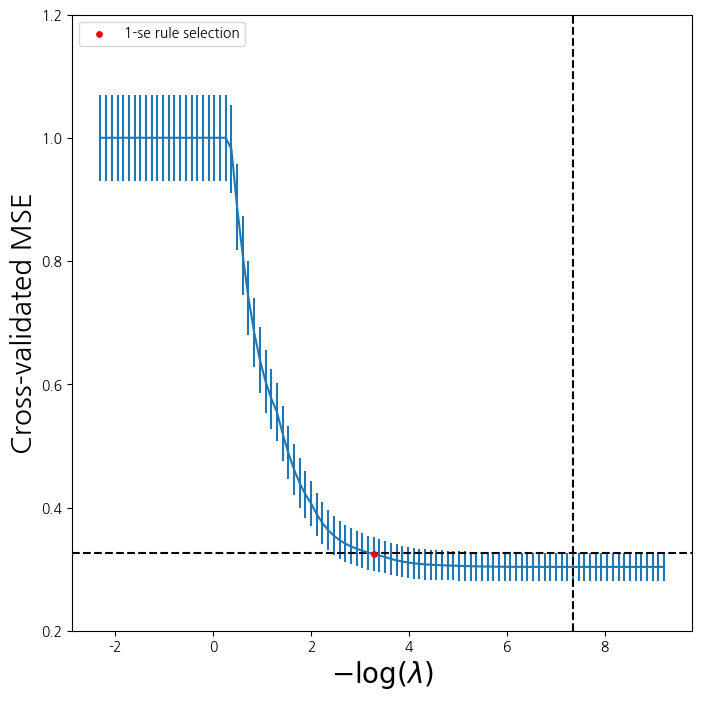

선택된 lambda =  0.03765


In [ ]:
## optimized value
mse_list = lassoCV.mse_path_.mean(1)
indx = np.where(mse_list == np.min(mse_list))
min_mse = mse_list[indx]
min_std = lassoCV.mse_path_.std(1)[indx]
simple_indx = np.min(np.where(mse_list <= min_mse + min_std / np.sqrt(10)))

## plotting
lassoCV_fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(-np.log(lassoCV.alphas_), lassoCV.mse_path_.mean(1),
            yerr=lassoCV.mse_path_.std(1) / np.sqrt(10))
ax.set_ylim([0.2 ,1.2])
ax.axvline(-np.log(lassoCV.alpha_), c='k', ls='--')
ax.axhline(min_mse + min_std / np.sqrt(10), c = 'k', ls = '--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.scatter(-np.log(lassoCV.alphas_[simple_indx]), mse_list[simple_indx],
           color = "red", s = 15, label = "1-se rule selection", zorder = 5)
plt.legend()
plt.show()

## showing parameter
optim_lasso = lassoCV.alphas_[simple_indx]
print(f'선택된 lambda = {optim_lasso : .5f}')